# ポアソン混合モデル

「ベイズ推論による機械学習入門」p.128~を参照．

こちらも参考になる．  
http://machine-learning.hatenablog.com/entry/2016/07/31/192012

In [1]:
!date

2019年 8月26日 月曜日 22時04分08秒 JST


In [2]:
%matplotlib inline
%matplotlib nbagg

import warnings
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats, special

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, display

warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'viridis'
sns.set_context('talk')

# ポアソン混合分布

In [3]:
class PoissonMixture:
    """
    Poisson Mixture model

    p(x, z, lmd, pi) = p(x|z, lmd)p(z|pi)p(lmd)p(pi)
    
    p(pi) = Dir(pi|alpha)
    p(lmd) = Gam(lmd_d,k|a, b)
    p(z|pi) = Cat(z_n|pi)
    p(x|z, lmd) = Poi(x_n,d|lmd_d,k)^(z_n,k)
    """
    
    def __init__(self, d=2, k=3, alpha=[10., 10., 10.], 
                 a=[1., 1., 1.], b=[1., 1., 1.]):
        
        if k != len(alpha):
            raise 'Category and dim should be same'
        
        # Dimension
        self.d = d
        self.k = k
        
        # Prior
        self.alpha = np.array(alpha)
        self.a = np.array(a)
        self.b = np.array(b)
        
    def sample_data(self, n=10):
        pi = np.random.dirichlet(self.alpha)
        lmd = np.array([[np.random.gamma(self.a[d, k], 1 / self.b[k]) for d in range(self.d)]
                        for k in range(self.k)])
        z = np.array([np.random.choice(self.k, p=pi) for _ in range(n)])
        x = np.array([[np.random.poisson(lmd[z[i], j]) for j in range(self.d)] 
                      for i in range(n)])

        return x, z

# 人口データのシミュレート

In [4]:
# Model
D = 2
K = 4
alpha = 100.0 * np.ones(K)
a = np.ones((D, K), dtype=float)
b = 0.01 * np.ones(K, dtype=float)
pmm = PoissonMixture(D, K, alpha, a, b)

#### 潜在変数の持つ値で色分けをしている．

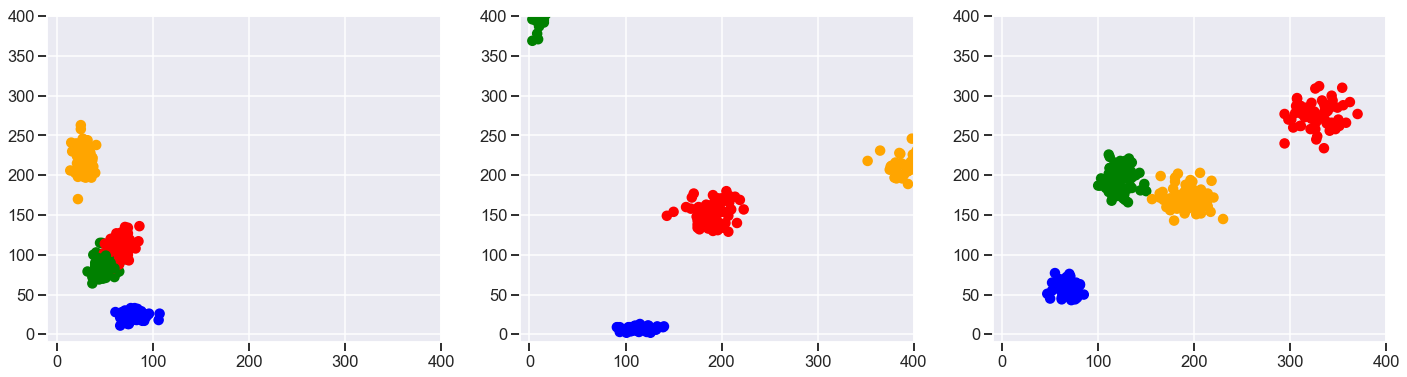

In [5]:
N = 300
colors = np.array(['b', 'r', 'g', 'orange'])
plt.figure(figsize=(24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    data, z = pmm.sample_data(N)

    # Plot
    plt.scatter(data[:, 0], data[:, 1], color=colors[z])
    plt.xlim([-10, 400])
    plt.ylim([-10, 400])
plt.show()

# Gibbs Sampling

In [45]:
class PMMGibbs(PoissonMixture):
    def __init__(self, d=2, k=3, alpha=[10., 10., 10.], 
                 a=[1., 1., 1.], b=[1., 1., 1.]):
        super().__init__(d, k, alpha, a, b)
        
        self.pi = np.random.dirichlet(self.alpha)
        self.lmd = np.array([[np.random.gamma(self.a[d, k], 1 / self.b[k])
                              for d in range(self.d)]
                             for k in range(self.k)])
        self.z = None
        
    def inference(self, x, max_iter=50):
        N = len(x)
        ret = np.zeros((max_iter, N), dtype=np.int32)
        
        for i in range(max_iter):
            # 1. Update z
            ln_eta = np.array([[np.sum(x[n] * np.log(self.lmd[k]) - self.lmd[k])
                                + np.log(self.pi[k])
                                for k in range(self.k)]
                               for n in range(N)])
            ln_eta -= special.logsumexp(ln_eta, axis=1)[:, None]
            self.z = np.array([np.random.choice(self.k, p=np.exp(ln_eta[n])) for n in range(N)])
            ret[i] = self.z

            # Update lambda
            print([np.sum(x * (self.z == k)[:, None], axis=0)
                                   for k in range(self.k)])
            a = self.a + np.array([np.sum(x * (self.z == k)[:, None], axis=0)
                                   for k in range(self.k)])
            b = self.b + np.array([np.sum(self.z == k) for k in range(self.k)])
            self.lmd = np.array([[np.random.gamma(a[d, k], 1 / b[k])
                                  for d in range(self.d)]
                                 for k in range(self.k)])
            
            # Update pi
            alpha = self.alpha + np.array([np.sum(self.z == k) for k in range(self.k)])
            self.pi = np.random.dirichlet(alpha)
            
        # Set posterior to new prior
        self.a = a
        self.b = b
        self.alpha = alpha
            
        return ret

# 2-カテゴリ・データに対する推論

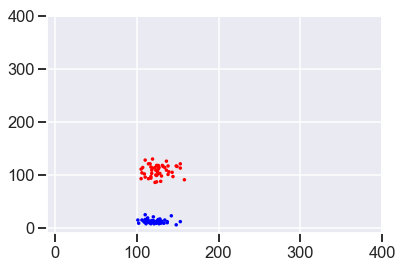

In [42]:
D = 2
K = 2
alpha = 100.0 * np.ones(K)
a = np.ones((D, K), dtype=float)
b = 0.01 * np.ones(K, dtype=float)
N = 100

pmm = PoissonMixture(D, K, alpha, a, b)
x_gen, z_gen = pmm.sample_data(N)

# Plot
colors = np.array(['b', 'r', 'g', 'orange'])
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=colors[z_gen], s=4)
plt.xlim([-10, 400])
plt.ylim([-10, 400])
plt.show()

### 推論アニメーション

In [46]:
MAX_ITER = 50
model = PMMGibbs(D, K, alpha, a, b)
z_pred = model.inference(x_gen, max_iter=MAX_ITER)

# Plot
colors = ['b', 'r', 'g', 'orange']
frames = []
fig, ax = plt.subplots()
ax.set_xlim([-10, 400])
ax.set_ylim([-10, 400])
for i in range(MAX_ITER):
    im = []
    for k in range(K):
        mask = z_pred[i] == k
        im_ = ax.plot(x_gen[mask, 0], x_gen[mask, 1], 'o', c=colors[k], markersize=4)
        im += im_
    frames.append(im)
    
plt.close()

[array([102,   9]), array([12244,  5824])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array([12346,  5833])]
[array([0, 0]), array

In [33]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())

# 4-カテゴリ・データに対する推論

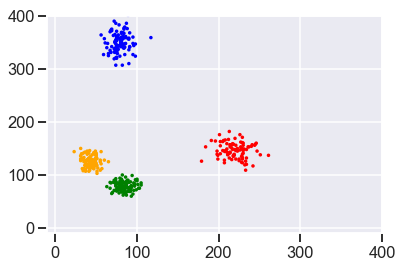

In [84]:
D = 2
K = 4
alpha = 100.0 * np.ones(K)
a = np.ones(K, dtype=float)
b = 0.01 * np.ones(K, dtype=float)
N = 400

pmm = PoissonMixture(D, K, alpha, a, b)
x_gen, z_gen = pmm.sample_data(N)

model = PMMGibbs(D, K, alpha, a, b)
z_pred = model.inference(x_gen)

# Plot
colors = np.array(['b', 'r', 'g', 'orange'])
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=colors[z_gen], s=4)
plt.xlim([-10, 400])
plt.ylim([-10, 400])
plt.show()

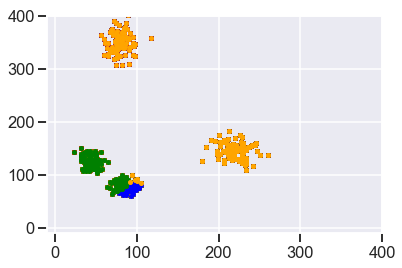

In [85]:
MAX_ITER = 50
model = PMMGibbs(D, K, alpha, a, b)
z_pred = model.inference(x_gen, max_iter=MAX_ITER)

# Plot
colors = ['b', 'r', 'g', 'orange']
frames = []
fig, ax = plt.subplots()
ax.set_xlim([-10, 400])
ax.set_ylim([-10, 400])
for i in range(MAX_ITER):
    im = []
    for k in range(K):
        mask = z_pred[i] == k
        im_ = ax.plot(x_gen[mask, 0], x_gen[mask, 1], 'o', c=colors[k], markersize=4)
        im += im_
    frames.append(im)
    
plt.close()

In [86]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())